In [2]:
import pandas as pd

# Read metabolite table
pos = pd.read_csv(
    "m_MTBLS8920_LC-MS_positive_hilic_metabolite_profiling_v2_maf.tsv",
    sep="\t"
)

# Extract metabolite → smiles
metabolite_smiles = pos[["database_identifier", "smiles"]].copy()

# Drop missing SMILES
metabolite_smiles = metabolite_smiles.dropna(subset=["smiles"])

# Drop problematic metabolite you already identified
metabolite_smiles = metabolite_smiles[
    metabolite_smiles["database_identifier"] != "CHEBI:172744"
].reset_index(drop=True)

metabolite_smiles.head()


,database_identifier,smiles
0,CHEBI:28619,MTBLS6894
1,CHEBI:35807,CN(C)N=O
2,CHEBI:41879,C1=CC(C=C2[C@]1([C@@]3([C@@](CC2)([C@]4([C@](C...
3,CHEBI:19092,C1CC=NC1
4,CHEBI:175520,O1C[C@](CC=2C1=CC(OC)=C(C2OC)CC=C(C)C)(C3=C4OC...


In [3]:
import numpy as np

# sample columns
sample_cols = [
    c for c in pos.columns
    if c.startswith("Breast_") or c.startswith("control_")
]

# abundance: sample × metabolite_id
abundance = pos.set_index("database_identifier")[sample_cols].T
abundance.index.name = "sample"

# ensure numeric
abundance = abundance.apply(pd.to_numeric, errors="coerce").fillna(0)

print("Abundance shape:", abundance.shape)


Abundance shape: (57, 493)


In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler

abundance_np = abundance.values.astype(float)
abundance_np = np.nan_to_num(abundance_np, nan=0.0)
abundance_np = np.log1p(abundance_np)

scaler_ab = StandardScaler()
abundance_np_scaled = scaler_ab.fit_transform(abundance_np)

abundance_scaled = pd.DataFrame(
    abundance_np_scaled,
    index=abundance.index,
    columns=abundance.columns
)


In [8]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

# Morgan fingerprint parameters
FP_DIM = 2048
RADIUS = 2

morgan_dict = {}

for _, row in metabolite_smiles.iterrows():
    met_id = row["database_identifier"]
    smi = row["smiles"]

    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue

    fp = AllChem.GetMorganFingerprintAsBitVect(
        mol,
        radius=RADIUS,
        nBits=FP_DIM
    )

    morgan_dict[met_id] = np.array(fp, dtype=np.float32)

print("Metabolites with Morgan FP:", len(morgan_dict))


[03:28:00] SMILES Parse Error: syntax error while parsing: MTBLS6894
[03:28:00] SMILES Parse Error: check for mistakes around position 1:
[03:28:00] MTBLS6894
[03:28:00] ^
[03:28:00] SMILES Parse Error: Failed parsing SMILES 'MTBLS6894' for input: 'MTBLS6894'
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: 

Metabolites with Morgan FP: 444


[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerator
[03:28:00] DEPRECATION WARNING: please use MorganGenerat

In [9]:
valid_mets = [m for m in abundance_scaled.columns if m in morgan_dict]

abundance_final = abundance_scaled[valid_mets]

print("Metabolites used:", len(valid_mets))


Metabolites used: 444


In [10]:
sample_embeddings = {}

for sample in abundance_final.index:
    emb_vec = np.zeros(FP_DIM, dtype=np.float32)

    for met in valid_mets:
        weight = abundance_final.loc[sample, met]   # normalized abundance
        emb = morgan_dict[met]                      # Morgan FP
        emb_vec += weight * emb

    sample_embeddings[sample] = emb_vec


In [12]:
import pandas as pd

meta_3 = pd.read_csv("s_MTBLS8920.txt", sep="\t")

meta_clean_3 = meta_3[~meta_3["Sample Name"].str.startswith("QC")].copy()

meta_ml_3 = meta_clean_3[["Sample Name", "Factor Value[Disease]"]].copy()

meta_ml_3 = meta_ml_3.rename(columns={
    "Sample Name": "sample",
    "Factor Value[Disease]": "disease"
})

meta_ml_3["label"] = meta_ml_3["disease"].map({
    "breast cancer": 1,
    "healthy control": 0
})


In [13]:
# sample × fingerprint
sample_embed_df = pd.DataFrame.from_dict(
    sample_embeddings,
    orient="index"
)
sample_embed_df.index.name = "sample"

# merge label
morgan_abundance_ML = sample_embed_df.merge(
    meta_ml_3[["sample", "label"]],
    on="sample",
    how="inner"
)

morgan_abundance_ML


,sample,0,1,2,3,4,5,6,7,8,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,label
0,Breast_1,-1.577821,-63.771938,2.519383,0.0,3.617110,2.881479,-0.578136,-1.131751,-14.571426,...,-1.525499,0.619345,-7.009365,0.480932,0.0,-1.841229,-0.770367,0.0,0.0,1
1,Breast_10,-0.462907,-131.428162,-1.773262,0.0,-0.264680,-1.044455,-3.338238,-2.205090,-12.198885,...,-2.123830,0.118527,-2.376938,-1.840528,0.0,1.806760,-0.984125,0.0,0.0,1
2,Breast_11,-0.058059,59.832901,1.802125,0.0,4.642465,-0.187619,-1.414549,-3.552037,-1.582109,...,-1.892688,1.364370,-1.210879,-2.946210,0.0,-0.358407,-1.337365,0.0,0.0,1
3,Breast_12,-0.001556,-75.632179,-0.360007,0.0,-0.747738,-2.223782,-0.968055,-1.586803,-8.690717,...,-0.696032,1.509288,-0.605615,-3.349327,0.0,-1.091852,3.288409,0.0,0.0,1
4,Breast_13,0.522558,-99.677444,-1.207039,0.0,-3.705719,-2.221539,-2.981936,-4.464425,-19.646568,...,-2.021634,0.362182,-2.012872,-2.203544,0.0,-0.237049,1.347519,0.0,0.0,1


In [19]:
nonzero_cols = (morgan_abundance_ML != 0).any(axis=0)

morgan_abundance_ML = morgan_abundance_ML.loc[:, nonzero_cols]
morgan_abundance_ML


,sample,0,1,2,4,5,6,7,8,9,...,2035,2037,2038,2039,2040,2041,2042,2044,2045,label
0,Breast_1,-1.577821,-63.771938,2.519383,3.617110,2.881479,-0.578136,-1.131751,-14.571426,-1.861321,...,0.406672,0.184906,25.807522,-1.525499,0.619345,-7.009365,0.480932,-1.841229,-0.770367,1
1,Breast_10,-0.462907,-131.428162,-1.773262,-0.264680,-1.044455,-3.338238,-2.205090,-12.198885,-0.352454,...,-1.560328,0.717220,-3.868195,-2.123830,0.118527,-2.376938,-1.840528,1.806760,-0.984125,1
2,Breast_11,-0.058059,59.832901,1.802125,4.642465,-0.187619,-1.414549,-3.552037,-1.582109,-0.670278,...,-2.544272,-0.683314,18.354477,-1.892688,1.364370,-1.210879,-2.946210,-0.358407,-1.337365,1
3,Breast_12,-0.001556,-75.632179,-0.360007,-0.747738,-2.223782,-0.968055,-1.586803,-8.690717,0.951084,...,-1.227247,0.302983,-12.904033,-0.696032,1.509288,-0.605615,-3.349327,-1.091852,3.288409,1
4,Breast_13,0.522558,-99.677444,-1.207039,-3.705719,-2.221539,-2.981936,-4.464425,-19.646568,0.079340,...,-4.855191,-1.832383,-6.097253,-2.021634,0.362182,-2.012872,-2.203544,-0.237049,1.347519,1
5,Breast_14,-0.377028,-80.549370,0.523497,0.415671,-2.513501,-2.294846,-2.822525,-11.954848,1.077436,...,-0.002535,0.119448,0.092159,-4.960733,-0.083534,-2.309518,-1.950238,2.953205,-0.614862,1
6,Breast_15,1.319680,69.906898,0.385082,-1.178573,0.971266,0.304147,0.287346,-1.421384,-1.366856,...,3.441972,1.117718,15.763485,-1.848888,-0.602811,1.913821,2.543114,-0.462794,0.700600,1
7,Breast_16,1.198593,30.092297,0.894240,2.330965,2.540152,0.504328,0.647401,-3.597660,-0.897405,...,2.745557,-2.432338,3.358941,0.669057,-0.387292,0.790129,0.113250,0.291465,-0.135850,1
8,Breast_17,0.323576,-11.748161,-0.108333,-0.279216,-0.562423,-1.027992,-1.954207,-5.068198,1.349519,...,-3.706210,0.801929,-6.272098,-1.540754,0.429791,0.338263,0.375218,2.936503,0.850150,1
9,Breast_18,0.161067,-21.364115,-1.977934,-1.733437,-0.819895,0.656544,-1.094090,0.861966,0.347395,...,-2.409920,0.340438,9.668518,-0.080603,-0.711015,1.650100,0.728260,2.203407,-0.558213,1


X shape: (57, 1616)
y shape: (57,)

Training: Logistic Regression
AUC: 0.8333
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.80      0.67      0.73         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12


Training: SVM (RBF kernel)
AUC: 0.8056
              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.50      0.17      0.25         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.44        12
weighted avg       0.50      0.50      0.44        12


Training: Random Forest
AUC: 0.9167
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.50      0.67         6

    accuracy               

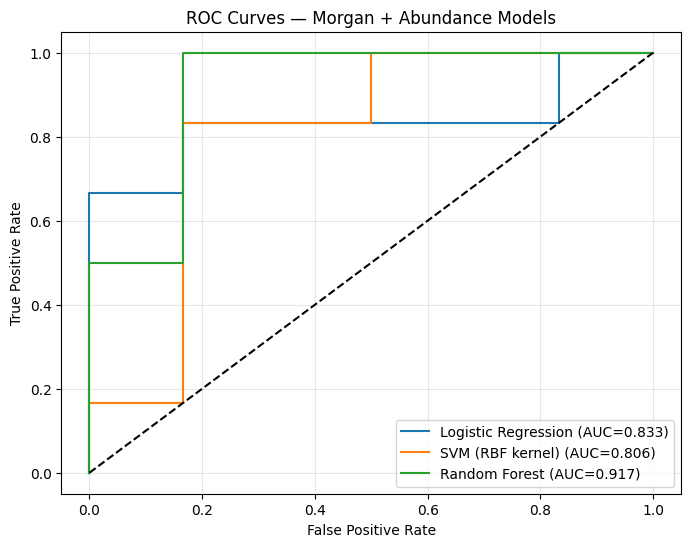

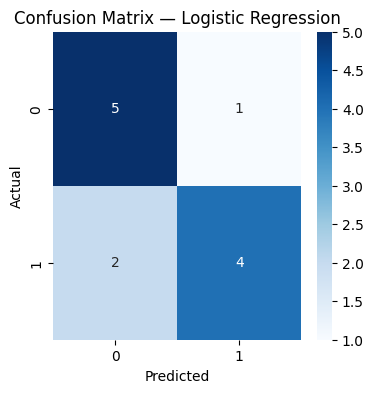

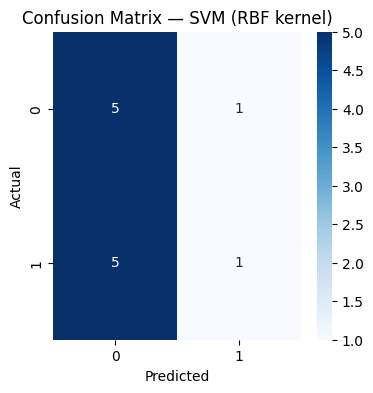

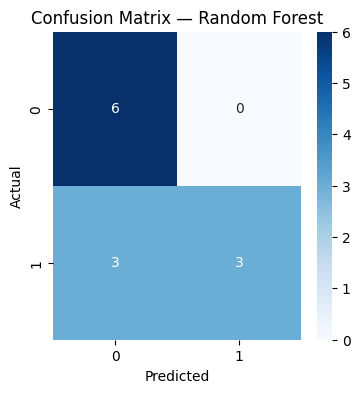



===== 5-fold Cross Validation (Morgan + Abundance) =====
Logistic Regression CV AUC: mean=0.8989, std=0.0731
SVM (RBF kernel) CV AUC: mean=0.8111, std=0.0916
Random Forest CV AUC: mean=0.9011, std=0.0861


In [21]:
# =============================
#  ML Baseline: Morgan + Abundance
# =============================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------
# 0. Define X, y (FROM morgan_abundance_ML)
# -------------------------------------
# morgan_abundance_ML columns:
# ['sample', feature_0, ..., feature_2045, 'label']

X = morgan_abundance_ML.drop(columns=["sample", "label"]).values
y = morgan_abundance_ML["label"].values

print("X shape:", X.shape)
print("y shape:", y.shape)

# -------------------------------------
# 1. Train-test split
# -------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -------------------------------------
# 2. Define models
# -------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM (RBF kernel)": SVC(kernel="rbf", probability=True),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    )
}

results = {}

# -------------------------------------
# 3. Train & Evaluate models
# -------------------------------------
for name, model in models.items():
    print(f"\n==============================")
    print(f"Training: {name}")
    print("==============================")

    # Train
    model.fit(X_train, y_train)

    # Predict probability for ROC
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    auc = roc_auc_score(y_test, y_prob)
    y_pred = model.predict(X_test)

    results[name] = {
        "model": model,
        "auc": auc,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(
            y_test, y_pred, output_dict=False
        )
    }

    print(f"AUC: {auc:.4f}")
    print(results[name]["classification_report"])

# -------------------------------------
# 4. Plot ROC curves
# -------------------------------------
plt.figure(figsize=(8, 6))

for name, result in results.items():
    model = result["model"]
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    plt.plot(
        fpr,
        tpr,
        label=f"{name} (AUC={result['auc']:.3f})"
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Morgan + Abundance Models")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# -------------------------------------
# 5. Plot confusion matrices
# -------------------------------------
for name, result in results.items():
    cm = result["confusion_matrix"]

    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# -------------------------------------
# 6. Cross-validation (5-fold)
# -------------------------------------
print("\n\n===== 5-fold Cross Validation (Morgan + Abundance) =====")

for name, model in models.items():
    cv_auc = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring="roc_auc"
    )
    print(f"{name} CV AUC: mean={cv_auc.mean():.4f}, std={cv_auc.std():.4f}")
